In [1]:
import numpy as np
import pandas as pd
from botorch.test_functions.synthetic import Ackley, AckleyMixed, Labs, Griewank
import torch
from sklearn.decomposition import PCA
from tqdm import tqdm

import sys
sys.path.append('../')
from roelfes_emulator import RoelfesEmulator
from vae import Autoencoder, WeightedAutoencoder
from bayesian_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt


c:\Users\danin\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def generate_random_inputs(bounds, q, discrete_inds=None):
    lower, upper = bounds  
    generated_samples = lower + (upper - lower) * torch.rand((q, bounds.shape[1]))
    if discrete_inds is not None:
        generated_samples[:, discrete_inds] = torch.round(generated_samples[:, discrete_inds])
    return generated_samples

In [4]:
def bayes_opt_roelfes_coef(objs, q, q_sampling_method="Monte Carlo"):
    lin_y_names= ['y1','y2']
    dec_exp_y_names = ['y3','y4','y5','y6']
    all_names = lin_y_names + dec_exp_y_names

    lin_df = objs.drop(dec_exp_y_names,axis=1)
    dec_exp_df = objs.drop(lin_y_names, axis=1)

    q1 = q // 2
    q2 = q - q1
    if q == 1:
        q1 = 1

    lin_bo_model = BayesianOptimization().fit(lin_df, y=lin_y_names)
    c1 = lin_bo_model.candidates(q1, export_df=True, q_sampling_method=q_sampling_method)
    dec_exp_bo_model = BayesianOptimization().fit(dec_exp_df, y=dec_exp_y_names, 
                                                optim_direc=['max','max', 'min','max'])
    c2 = dec_exp_bo_model.candidates(q2, export_df=True,q_sampling_method=q_sampling_method)
    cand = pd.concat((c1, c2)).fillna(0)
    pred = cand[all_names].to_numpy()
    cand = cand.drop(all_names, axis=1).to_numpy()
    if q == 1:
        choice = np.random.randint(0,2)
        return cand[choice,:], pred[choice,:]
        
    return cand, pred

In [5]:
# function_list = [Ackley(dim=50), AckleyMixed(dim=53), Labs(dim=50),
#     Griewank(dim=50), RoelfesEmulator(dim=50, objective="coef", use_torch=True), RoelfesEmulator(dim=50, objective="max yield",use_torch=True),
#     RoelfesEmulator(dim=50, objective="normalized yield gradient", use_torch=True)]
# for function in function_list:
#   #optim_direc = #choose as a list based on whether we maximize y or minimize, not needed for  RoelfesEmulator(dim=50, objective="coef", use_torch=True)
#   for cv_iter in range(cv_amount):
#       #uses torch
#       X = generate_random_inputs(function.bounds, starting_samples_n, function.discrete_inds)
#       y = function(y)
#       x_np, y_np = X.numpy(), y.numpy()
#       for dim_reduc_method in dim_red_list (PCA, VAE, WeightedVAE, None):
#           for n_components in test_component_choice_list: ([2,16,32])
#               for q_sampling_method in sampling_strategies "Monte Carlo" or "Believer":
#                 if dim_reduc_method is not None:
#                     dr_model = dim_reduc_method(n_components=n_components)   
#                     for bayes_iter in range(500):
#                           if dim_reduc_method is WeightedVAE:
#                               x_np = dr_model.fit_transform(x_np,y_np, optim_direc=optim_direc)
#                           elif dim_reduc_method is not None:
#                               x_np = dr_model.fit_transform(x_np)
#                           x_columns = [f'x{i+1}' for i in range(x_np.shape[1])]
#                           y_columns = [f'y{i+1}' for i in range(y_np.shape[1])]
#                           df = pd.DataFrame(
#                               data = np.hstack((x_np, y_np)),
#                               columns = x_columns + y_columns)
#                           if function is RoelfesEmulator(dim=50, objective="coef", use_torch=True):
#                             cand, pred = bayes_opt_roelfes_coef(df, q, q_sampling_method)
#                           else:
#                             model = BayesianOptimization().fit(df, y_columns, optim_direc=optim_direc)      
#                             cand, pred = model.candidates(q, q_sampling_method=q_sampling_method)
#                           recon_cand = dr_model.inverse_transform(cand)
#                           new_y = function(torch.tensor(recon_cand)).numpy()
#                           x_np = np.vstack(x_np, recon_cand)
#                           #r2_score(y_np, new_y)?
#                           #best = np.max(new_y)?
#                           #best has to be calculated by taking into account multi objectives and whether max or min. 
#                           #use wieghts defined below for this
#                           #weights = [1 if val == "max" else -1 if val == "min" else val for val in optim_direc]
#                           #somehow store the best per bo_iter 
#                           y_np = np.vstack(y_np, new_y)
#                           #I also want to compare differences between y_np and new_y and save them to a list
#       #get average best_cand_vals per bo iteration  and average differences between y_np and new_y. average with respect to cv_folds, 
#       # we will have many many configurations, so this might be a dict of dicts of dicts of dicts, total of 7 * 4* 3 * 2 options

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

np.random.seed(42)

starting_samples_n = 96
bo_iter_amount = 25
dim_red_list = [PCA, None, Autoencoder, WeightedAutoencoder]
test_component_choice_list = [2, 16, 32]
sampling_strategies = ["Monte Carlo", "Sequential"]
cv_amount = 5
q_list = [1, 2, 4, 16, 96]

# Define your functions with names
function_list = [
    ("RoelfesCoef", RoelfesEmulator(dim=50, objective="coef", use_torch=True)),
    ("Ackley", Ackley(dim=50)),
    ("AckleyMixed", AckleyMixed(dim=53)),
    ("Labs", Labs(dim=50)),
    ("Griewank", Griewank(dim=50)),
    ("RoelfesMaxYield", RoelfesEmulator(dim=50, objective="max yield", use_torch=True)),
    ("RoelfesNormGrad", RoelfesEmulator(dim=50, objective="normalized yield gradient", use_torch=True)),
]

# Define optimization directions
optim_direc_map = {
    "RoelfesCoef": ["max", "max", "max", "max", "min", "max"],
    "Ackley": ["min"],
    "AckleyMixed": ["min"],
    "Labs": ["min"],
    "Griewank": ["min"],
    "RoelfesMaxYield": ["max"],
    "RoelfesNormGrad": ["max"],
}

# Results storage
results = {}
data = {}

# Main experiment loop
for function_name, function in tqdm(function_list):
    optim_direc = optim_direc_map[function_name]
    weights = np.array([1 if d == "max" else -1 for d in optim_direc])

    if function_name not in results:
        results[function_name] = {}
        data[function_name] = {}

    for cv_iter in (range(cv_amount)):
        X = generate_random_inputs(function.bounds, starting_samples_n, function.discrete_inds)
        y = function(X)
        x_np, y_np = X.numpy(), y.numpy()
        x_np_backup, y_np_backup = x_np, y_np

        for dr_method in dim_red_list:
            x_np, y_np = x_np_backup, y_np_backup
            dr_name = dr_method.__name__ if dr_method else "None"
            if dr_name not in results[function_name]:
                results[function_name][dr_name] = {}
                data[function_name][dr_name] = {}

            for n_components in (test_component_choice_list):
                x_np, y_np = x_np_backup, y_np_backup
                if n_components not in results[function_name][dr_name]:
                    results[function_name][dr_name][n_components] = {}
                    data[function_name][dr_name][n_components] = {}

                for q in q_list:
                    if q > 1:
                        relevant_sampling_strategies = sampling_strategies
                    else:
                        relevant_sampling_strategies = [None]

                    for q_method in relevant_sampling_strategies:
                        x_np, y_np = x_np_backup, y_np_backup
                        q_key = f"q{q}_{q_method or 'None'}"
                        if q_key not in results[function_name][dr_name][n_components]:
                            results[function_name][dr_name][n_components][q_key] = {
                                "x": [],
                                "best_vals_all_folds": [],
                                "mae_vals_all_folds": [],
                                "recon_mae_all_folds": []
                            }
                            data[function_name][dr_name][n_components][q_key] = {}

                        best_vals = []
                        mae_pred_vals = []
                        recon_mae_vals = []

                        for bo_iter in range(bo_iter_amount):
                            
                            if dr_method:

                                dr_model = dr_method(n_components=n_components)
                                if dr_name == "WeightedAutoencoder":
                                    x_np_dr = dr_model.fit_transform(x_np, y_np, optim_direc=optim_direc)
                                    x_np_recon = dr_model.inverse_transform(x_np_dr)
                                    recon_mae_vals.append(mean_absolute_error(x_np_recon, x_np))
                                else:
                                    x_np_dr = dr_model.fit_transform(x_np)
                                    x_np_recon = dr_model.inverse_transform(x_np_dr)
                                    recon_mae_vals.append(mean_absolute_error(x_np_recon, x_np))
                            else:
                                x_np_dr = x_np
                                recon_mae_vals.append(mean_absolute_error(x_np_dr, x_np))

                            x_cols = [f"x{i+1}" for i in range(x_np_dr.shape[1])]
                            if len(optim_direc) > 1:
                                y_cols = [f"y{i+1}" for i in range(y_np.shape[1])]
                            else:
                                y_cols = ['y1']
                                y_np = y_np.reshape(len(y_np), 1)
                            df = pd.DataFrame(np.hstack([x_np_dr, y_np]), columns=x_cols + y_cols)

                            if isinstance(function, RoelfesEmulator) and function.objective == "coef":
                                cand, pred = bayes_opt_roelfes_coef(df, q, q_method)
                                pred = pred.reshape(q, len(optim_direc))
                            else:
                                model = BayesianOptimization().fit(df, y_cols, optim_direc=optim_direc)
                                cand, pred = model.candidates(q, q_sampling_method=q_method)

                            recon_cand = dr_model.inverse_transform(cand) if dr_method else cand
                            rc_tensor = torch.tensor(recon_cand)
                            recon_cand = torch.max(torch.min(rc_tensor, function.bounds[1].unsqueeze(0)),
                                                   function.bounds[0].unsqueeze(0))
                            if function.discrete_inds is not None:
                                recon_cand[:, function.discrete_inds] = torch.round(recon_cand[:, function.discrete_inds])
                            if q > 1:
                                new_y = function(recon_cand).numpy().reshape(q, len(optim_direc))
                            else:
                                new_y = function(recon_cand).numpy()
                            recon_cand = rc_tensor.numpy()

                            scalar_y = np.dot(new_y, weights.T) if len(weights) > 1 else new_y.flatten() * weights[0]
                            best_vals.append(np.max(scalar_y))

                            pred_np = np.array(pred)
                            mae_pred_vals.append(mean_absolute_error(pred_np, new_y))

                            x_np = np.vstack([x_np, recon_cand])
                            y_np = np.vstack([y_np, new_y])

                        results[function_name][dr_name][n_components][q_key]["x"].append(x_np)
                        results[function_name][dr_name][n_components][q_key]["best_vals_all_folds"].append(best_vals)
                        results[function_name][dr_name][n_components][q_key]["mae_vals_all_folds"].append(mae_pred_vals)
                        results[function_name][dr_name][n_components][q_key]["recon_mae_all_folds"].append(recon_mae_vals)

# Final aggregation
for fname in results:
    for dr in results[fname]:
        for comp in results[fname][dr]:
            for q_key in results[fname][dr][comp]:
                data[fname][dr][comp][q_key]["best_vals_avg"] = np.mean(
                    results[fname][dr][comp][q_key]["best_vals_all_folds"], axis=0)
                data[fname][dr][comp][q_key]["mae_vals_avg"] = np.mean(
                    results[fname][dr][comp][q_key]["mae_vals_all_folds"], axis=0)
                data[fname][dr][comp][q_key]["recon_mae_avg"] = np.mean(
                    results[fname][dr][comp][q_key]["recon_mae_all_folds"], axis=0)

  0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_bo_results_from_data(data,
                              fixed_params=None,
                              plot_metric='best_vals_avg',
                              show_legend=True,
                              legend_loc='upper left'):
    fixed_params = fixed_params or {}

    # Infer keys
    function_names = [fixed_params.get('function_name')] if fixed_params.get('function_name') else list(data.keys())
    dim_reds = set()
    n_components_list = set()
    q_keys = set()

    for fn in function_names:
        for dr in data.get(fn, {}):
            dim_reds.add(dr)
            for nc in data[fn][dr]:
                n_components_list.add(nc)
                for qk in data[fn][dr][nc]:
                    q_keys.add(qk)

    # Parse q_keys into structured q + strategy
    q_strat_pairs = []
    for qk in q_keys:
        if qk.startswith("q"):
            try:
                q_val, strat = qk[1:].split("_", 1)
                q_strat_pairs.append((int(q_val), strat))
            except Exception:
                continue

    q_list = sorted(set(q for q, _ in q_strat_pairs))
    sampling_strategies = sorted(set(s for _, s in q_strat_pairs))

    # Build variation set
    vary_params = []
    for p, vals in [('function_name', function_names),
                    ('dim_red', sorted(dim_reds, key=str)),
                    ('n_components', sorted(n_components_list, key=lambda x: int(x) if x is not None else -1)),
                    ('q', q_list),
                    ('sampling_strategy', sampling_strategies)]:
        if fixed_params.get(p) is None:
            vary_params.append(p)

    plt.figure(figsize=(10, 6))

    for combo in itertools.product(*[
        function_names if p == 'function_name' else
        sorted(dim_reds, key=str) if p == 'dim_red' else
        sorted(n_components_list, key=lambda x: int(x) if x is not None else -1) if p == 'n_components' else
        q_list if p == 'q' else
        sampling_strategies
        for p in vary_params
    ]):
        params = fixed_params.copy()
        for i, p in enumerate(vary_params):
            params[p] = combo[i]

        fn = params['function_name']
        dr = params['dim_red']
        nc = params['n_components']
        q = params['q']
        strat = params['sampling_strategy']
        q_key = f"q{q}_{strat}"

        try:
            result = data[fn][dr][nc][q_key]
            y = result.get(plot_metric)
            if y is None:
                continue
            x = range(1, len(y) + 1)

            label_parts = []
            if fixed_params.get("function_name") is None:
                label_parts.append(fn)
            if fixed_params.get("dim_red") is None:
                label_parts.append(str(dr))
            if fixed_params.get("n_components") is None:
                label_parts.append(f"comp={nc}")
            if fixed_params.get("q") is None:
                label_parts.append(f"q={q}")
            if fixed_params.get("sampling_strategy") is None:
                label_parts.append(f"strat={strat}")

            label = ", ".join(label_parts)
            plt.plot(x, y, label=label)

        except KeyError:
            continue

    plt.xlabel('BO Iteration')
    ylabel = {
        'best_vals_avg': 'Average Best Value',
        'mae_vals_avg': 'Average MAE (Prediction)',
        'recon_mae_avg': 'Average MAE (Reconstruction)',
    }.get(plot_metric, plot_metric)
    plt.ylabel(ylabel)
    # Create descriptive title from fixed_params
    title_parts = [f"BO - {ylabel}"]
    for key in ['function_name', 'dim_red', 'n_components', 'q', 'sampling_strategy']:
        if key in fixed_params:
            value = fixed_params[key]
            title_parts.append(f"{key}={value}")
    plt.title(" | ".join(title_parts))

    if show_legend:
        plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc=legend_loc)
    plt.tight_layout()
    plt.show()

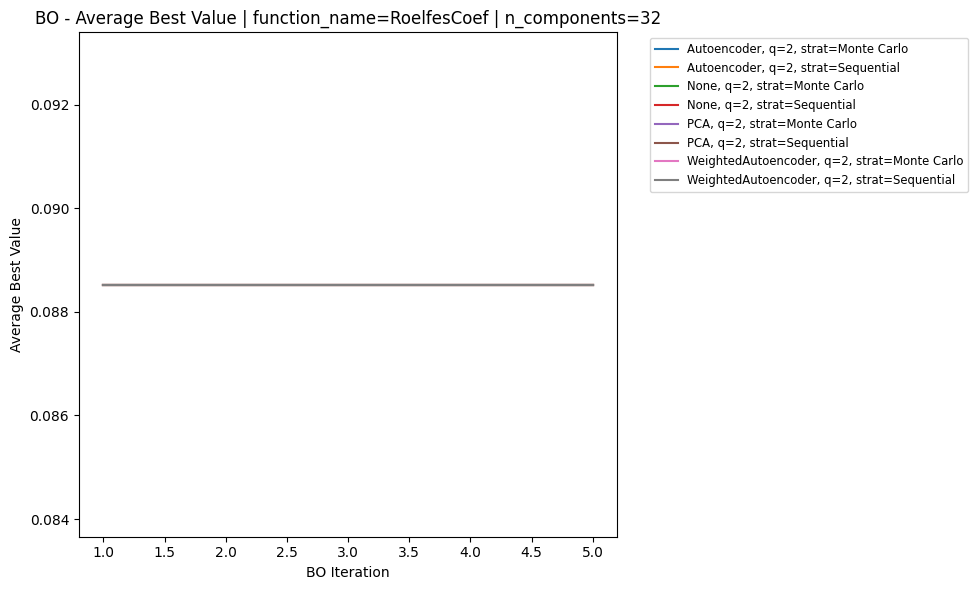

In [ ]:
plot_bo_results_from_data(data, plot_metric='best_vals_avg',
                fixed_params={'function_name':'RoelfesCoef', 'n_components':32,})